In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report ,confusion_matrix
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D,Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from keras.regularizers import l2
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image 

2024-05-30 22:29:53.151091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 22:29:53.151224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 22:29:53.289365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **DEEP LEARNING PROJECT**
Final Model Test Accuracy: 86.31%

## **Data**

### **Importing Data**
We have 429 images in training data, 168 images in both validation and test data.

In [2]:
# DATA IMPORT FUNCTION
def data_process(directory, label, x_list, y_list):
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            # Read the image
            image = Image.open(os.path.join(dirname, filename)).convert('RGB')
            # Resize the image to the target size
            image = image.resize((224, 224))
            # Convert image to numpy array and normalize
            image_array = np.array(image) / 255.0
            # Append to the lists
            x_list.append(image_array)
            y_list.append(label)

# Label encoder initialization
label_encoder = LabelEncoder()
                   
# TRAIN DATA
x_train, y_train = [], []
# Import data
data_process('/kaggle/input/picture-classification/train/nathalie', 'nathalie', x_train, y_train)
data_process('/kaggle/input/picture-classification/train/keira', 'keira', x_train, y_train)
data_process('/kaggle/input/picture-classification/train/others', 'others', x_train, y_train)
# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# VALIDATION DATA
x_val, y_val = [], []
# Import data
data_process('/kaggle/input/picture-classification/val/nathalie', 'nathalie', x_val, y_val)
data_process('/kaggle/input/picture-classification/val/keira', 'keira', x_val, y_val)
data_process('/kaggle/input/picture-classification/val/others', 'others', x_val, y_val)
# Convert lists to numpy arrays
x_val = np.array(x_val)
y_val = np.array(y_val)

# Test data
x_test, y_test = [], []
# Import data
data_process('/kaggle/input/picture-classification/test/nathalie', 'nathalie', x_test, y_test)
data_process('/kaggle/input/picture-classification/test/keira', 'keira', x_test, y_test)
data_process('/kaggle/input/picture-classification/test/others', 'others', x_test, y_test)
# Convert lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Data Shape
print('Train Data:',x_train.shape)
print('Validation Data:',x_val.shape)
print('Test Data:',x_test.shape)

Train Data: (429, 224, 224, 3)
Validation Data: (168, 224, 224, 3)
Test Data: (168, 224, 224, 3)


### **Display Data**  
Data is composed of 3 balanced categories : Nathalie, Keira, Others

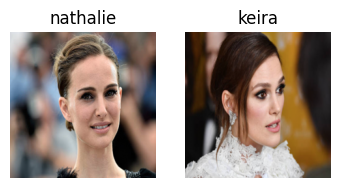

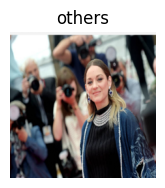

In [3]:
# Display of some pictures

plt.subplot(1,3,1)
plt.title(y_train[2])
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.imshow(x_train[2])

plt.subplot(1,3,2)
plt.title(y_train[200])
plt.imshow(x_train[200])
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.show()

plt.subplot(1,3,3)
plt.title(y_train[421])
plt.imshow(x_train[421])
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.show()

### **Data Augmentation**  
Given small number of data, data augmentation is necessary. Among different data augmentation I have tried, keeping both the original data and transformed data worked the better. Final training data has 4719 images.

In [4]:
# Augmente train data
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Store augmented train data
augmented_images = []
augmented_labels = []
for i in range(len(x_train)):
    x = x_train[i]  # (height, width, channels)
    y = y_train[i]
    x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)
    j = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(y)
        j += 1
        if j >= 10:  # Generate 2 augmented images per original image
            break

# Transform augmented data in array
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original train data + augmented data
x_train_augmented = np.concatenate((x_train, augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

# Apply label encoder to target
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train_augmented)) # Train label
y_val_encoded = to_categorical(label_encoder.fit_transform(y_val)) # Validation label
y_test_encoded = to_categorical(label_encoder.fit_transform(y_test)) # Test label

# Data Generator Initalization
train_datagen = ImageDataGenerator()

# Create generators
batch_size = 32
steps_per_epoch = int(np.ceil(1000 / batch_size)) 

train_generator = train_datagen.flow(x_train_augmented, y_train_encoded, batch_size=batch_size)
validation_generator = train_datagen.flow(x_val, y_val_encoded, batch_size=batch_size)
test_generator = train_datagen.flow(x_test, y_test_encoded, batch_size=batch_size)

# Augmented data shape
print('Augmented Train Data:',x_train_augmented.shape)

Augmented Train Data: (4719, 224, 224, 3)


## **Models**  
I tried three models of Convolutional Neural Networks to classify the data: VGG, LeNet, and EfficientNet.

### **VGG**  
The basic VGG16 model gave a test accuracy of **33.33%**. The model seems too complex for the data, so testing a simpler model might be worthwhile.

In [5]:
# Input Shape
input_shape = (224, 224, 3)
# Number of classes
n_classes = 3
# Learning Rate
reduced_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,min_lr=0.0001)
# Optimizer
optimizer = Adam(learning_rate=1e-3)


# Initialize the model
vgg = Sequential()
# Input
vgg.add(Input(shape=input_shape))
#Add the VGG base model
vgg_base = VGG16(include_top=False)
vgg.add(vgg_base)
# Add fully connected layers
vgg.add(Flatten())
vgg.add(Dense(512, activation='relu'))
vgg.add(Dense(512, activation='relu'))
vgg.add(Dense(n_classes, activation='softmax'))

# Compile the model
vgg.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = vgg.fit(train_generator, 
                  epochs=30, 
                  validation_data=validation_generator, 
                  callbacks=reduced_learning_rate)

# Evaluate the model
loss, accuracy = vgg.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-30 22:31:11.819288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-30 22:31:11.819362: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-30 22:31:11.819371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-30 22:31:11.819379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-30 22:31:11.819387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

 77/148 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.3042 - loss: 1.7991

2024-05-30 22:32:03.392850: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.00564, expected 3.36194
2024-05-30 22:32:03.392912: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.21235, expected 4.56865
2024-05-30 22:32:03.392928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 5.39965, expected 4.75595
2024-05-30 22:32:03.392945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.25668, expected 4.61298
2024-05-30 22:32:03.392958: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.55266, expected 2.90896
2024-05-30 22:32:03.392968: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.84224, expected 4.19854
2024-05-30 22:32:03.392978: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.23174, expected 3.58804
2024-05-30 22:32:03.392988: E external/local_xla/x

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3133 - loss: 1.5461

2024-05-30 22:32:37.373277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.39009, expected 3.53025
2024-05-30 22:32:37.373352: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.40727, expected 4.54742
2024-05-30 22:32:37.373369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.56026, expected 4.70042
2024-05-30 22:32:37.373390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.58812, expected 4.72827
2024-05-30 22:32:37.373404: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.9643, expected 4.10445
2024-05-30 22:32:37.373415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.19898, expected 4.33914
2024-05-30 22:32:37.373425: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.47066, expected 4.61082
2024-05-30 22:32:37.373436: 

148/148 ━━━━━━━━━━━━━━━━━━━━ 97s 378ms/step - accuracy: 0.3134 - loss: 1.5440 - val_accuracy: 0.3333 - val_loss: 2.0333 - learning_rate: 0.0010
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.3276 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 2.3152 - learning_rate: 0.0010
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.3395 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 2.5856 - learning_rate: 0.0010
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.3479 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.9250 - learning_rate: 0.0010
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.3321 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.5687 - learning_rate: 0.0010
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.3295 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 2.2057 - learning_rate: 0.0010
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.3400 - loss:

### **LeNet**  
Using a simpler model improved performance, achieving a test accuracy of **42.86%**, but the result is still weak. Deeper model is tested next.

In [6]:
# Input Shape
input_shape = (224, 224, 3)
# Number of classes
n_classes = 3
# Learning Rate
reduced_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,min_lr=0.0001)
# Optimizer
optimizer = Adam(learning_rate=1e-3)


# Initialize the model
lenet = Sequential()
# Input
lenet.add(Input(shape=input_shape))
# Add convolutional and pooling layers 1
lenet.add(Conv2D(6, (5, 5), activation='relu'))
lenet.add(AveragePooling2D(pool_size = (2,2)))
# Add convolutional and pooling layers 2
lenet.add(Conv2D(16, (5, 5), activation='relu'))
lenet.add(AveragePooling2D(pool_size = (2,2)))
# Add fully connected layers
lenet.add(Flatten())
lenet.add(Dense(120, activation='relu'))
lenet.add(Dense(84, activation='relu'))
lenet.add(Dense(n_classes, activation="softmax"))

# Compile the model
lenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = lenet.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=reduced_learning_rate)

# Evaluate the model
loss, accuracy = lenet.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.3769 - loss: 1.3237 - val_accuracy: 0.3690 - val_loss: 1.0947 - learning_rate: 0.0010
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4967 - loss: 0.9954 - val_accuracy: 0.3810 - val_loss: 1.0860 - learning_rate: 0.0010
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6216 - loss: 0.8280 - val_accuracy: 0.3869 - val_loss: 1.2292 - learning_rate: 0.0010
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7634 - loss: 0.5868 - val_accuracy: 0.4048 - val_loss: 1.2613 - learning_rate: 0.0010
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8929 - loss: 0.3024 - val_accuracy: 0.4167 - val_loss: 1.9481 - learning_rate: 0.0010
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9615 - loss: 0.1212 - val_accuracy: 0.4345 - val_loss: 2.5296 - learning_rate: 0.0010
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9876 - loss: 0

### **EfficientNetB2**  
EfficientNet is very performant and achieved a satisfactory test accuracy of **83.93%**.

In [7]:
# Input Shape
input_shape = (224, 224, 3)
# Number of classes
n_classes = 3
# Learning Rate
reduced_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,min_lr=0.0001)
# Optimizer
optimizer = Adam(learning_rate=1e-3)


# Initialize the model
efficient = Sequential()
# Input
efficient.add(Input(shape=input_shape))
# Add the EfficientNetB2 base model
efficient_base = EfficientNetB2(include_top=False, weights='imagenet')
efficient.add(efficient_base)
# Add the top layers
efficient.add(GlobalAveragePooling2D())
efficient.add(Dense(n_classes, activation='softmax'))
# Compile the model
efficient.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = efficient.fit(train_generator, epochs=30, validation_data=validation_generator,callbacks=[reduced_learning_rate])

# Evaluate the model
loss, accuracy = efficient.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 281s 943ms/step - accuracy: 0.7969 - loss: 0.4644 - val_accuracy: 0.3333 - val_loss: 1.3832 - learning_rate: 0.0010
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.9725 - loss: 0.0800 - val_accuracy: 0.3214 - val_loss: 1.6511 - learning_rate: 0.0010
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - accuracy: 0.9800 - loss: 0.0572 - val_accuracy: 0.3333 - val_loss: 2.2419 - learning_rate: 0.0010
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.9874 - loss: 0.0380 - val_accuracy: 0.3571 - val_loss: 2.3181 - learning_rate: 0.0010
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9924 - loss: 0.0276 - val_accuracy: 0.6190 - val_loss: 2.1114 - learning_rate: 0.0010
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.9917 - loss: 0.0277 - val_accuracy: 0.6429 - val_loss: 2.2241 - learning_rate: 0.0010
Epoch 7/30
148/148

**Regularisation**  
My final model was obtained by regularizing the initial EfficientNet model. The best regularization was achieved by implementing the dropout method, resulting in a test accuracy of **86.31%**.

In [8]:
# Input Shape
input_shape = (224, 224, 3)
# Number of classes
n_classes = 3
# Learning Rate
reduced_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,min_lr=0.0001)
# Optimizer
optimizer = Adam(learning_rate=1e-3)


# Initialize the model
efficient = Sequential()
# Input
efficient.add(Input(shape=input_shape))
# Add the EfficientNetB2 base model
efficient_base = EfficientNetB2(include_top=False, weights='imagenet')
efficient.add(efficient_base)
# Add the top layers
efficient.add(GlobalAveragePooling2D())
efficient.add(Dropout(0.1))
efficient.add(Dense(n_classes, activation='softmax'))
# Compile the model
efficient.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = efficient.fit(train_generator, epochs=30, validation_data=validation_generator,callbacks=[reduced_learning_rate])

# Evaluate the model
loss, accuracy = efficient.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 242s 800ms/step - accuracy: 0.8143 - loss: 0.4482 - val_accuracy: 0.3333 - val_loss: 1.7161 - learning_rate: 0.0010
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.9697 - loss: 0.0864 - val_accuracy: 0.3274 - val_loss: 123.8030 - learning_rate: 0.0010
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.9841 - loss: 0.0459 - val_accuracy: 0.4762 - val_loss: 2.7998 - learning_rate: 0.0010
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.9902 - loss: 0.0326 - val_accuracy: 0.5060 - val_loss: 1.2687 - learning_rate: 0.0010
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.9848 - loss: 0.0517 - val_accuracy: 0.6845 - val_loss: 1.2298 - learning_rate: 0.0010
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.9919 - loss: 0.0219 - val_accuracy: 0.6429 - val_loss: 1.8885 - learning_rate: 0.0010
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step - accuracy: 